In [1]:
import pandas as pd
from datasets import load_dataset
from sklearn.metrics import f1_score, precision_score, recall_score, \
    accuracy_score

import re
from typing import List, Tuple

import pandas as pd


def is_contained(inner_start, inner_end, outer_start, outer_end):
    return (
        outer_start <= inner_start <= outer_end
        and outer_start <= inner_end <= outer_end
        and (inner_start, inner_end) != (outer_start, outer_end)
    )


def find_all_occurrences_indices(
    sentence: str,
    label: str,
) -> List[Tuple[int, int]]:
    """
    Finds all occurrences of a label in a sentence and returns a list of tuples
    with the start and end indices of the occurrences.

    Args:
        sentence: The sentence to search in.
        label: The label to search for.

    Returns:
        A list of tuples with the start and end indices of the occurrences.
    """
    return [
        (int(match.start()), int(match.end()))
        for match in re.finditer(label, sentence)
    ]


def find_contained_labels(labels):
    """
    Finds all labels that are contained in other labels.

    Args:
        labels: A list of labels.

    Returns:
        A dictionary with the labels as keys and a list of labels that are
        contained in the key label as values.
    """
    return {
        label_1: [
            label2
            for label2 in labels
            if label_1 in label2 and label_1 != label2
        ]
        for label_1 in labels
    }


def find_labels_in_sentence(
    sentence: str,
    labels: List[str],
) -> List[List[Tuple[int, int]]]:
    """
    Finds all occurrences of the labels in a sentence and returns a list of
    lists with the occurrences of each label.

    Labels that are contained in other labels are not returned.

    Args:
        sentence: The sentence to search in.
        labels: The labels to search for.

    Returns:
        A list of lists with the positional occurrence of each label.
    """
    if not labels:
        return []

    containable_map = find_contained_labels(labels)
    sentence_lower = sentence.lower()
    occurrences = [
        find_all_occurrences_indices(sentence_lower, label.lower())
        for label in labels
    ]
    label_occurrences = dict(zip(labels, occurrences))
    included_list = []
    for label, inner_pos in zip(labels, occurrences):
        contained = set()
        containing_labels = containable_map.get(label, set())

        for bigger_label in containing_labels:
            locations: List[Tuple[int, int]] = label_occurrences.get(
                bigger_label,
                list(),
            )

            for inner_start, inner_end in inner_pos:
                for outer_start, outer_end in locations:
                    if is_contained(
                        inner_start,
                        inner_end,
                        outer_start,
                        outer_end,
                    ):
                        contained.add((inner_start, inner_end))
        included_list.append(list(contained))

    return [
        list(set(pos) - set(included))
        for pos, included in zip(occurrences, included_list)
    ]


def find_label(
    sentence: str,
    labels: List[str],
    default_label: str = "?",
) -> str:
    """
    Search for given labels in the sentence and returns it if found. If only
    one label occur in the sentence, it will be returned. If no label or
    different labels occur in the sentence, '?' is returned.

    Args:
        sentence: The sentence to search in.
        labels: The labels to search for.
        default_label: The label to return if no label or different labels
            occur in the sentence.

    Returns:
        The label that occurs in the sentence or '?' if no label occurs in the
        sentence.
    """
    occurrences = find_labels_in_sentence(sentence=sentence, labels=labels)
    non_empty_indices = [i for i, sublist in enumerate(occurrences) if sublist]
    return (
        labels[non_empty_indices[0]]
        if len(
            non_empty_indices,
        )
           == 1
        else default_label
    )


def _soft_parse(
    df: pd.DataFrame,
    in_col: str,
    parsed_col: str,
    labels: List[str] = None,
) -> pd.DataFrame:
    if labels is None:
        raise ValueError("Labels are not set!")

    df[parsed_col] = df[in_col].apply(
        lambda x: find_label(x, labels),
    )


In [2]:

# load

# load results
df_falcon_7b = pd.read_csv(f"./data/falcon-7b-instruct.csv")
df_flan_t5_base = pd.read_csv("./data/flan-t5-base.csv")
df_flan_t5_large = pd.read_csv("./data/flan-t5-large.csv")
df_flan_t5_xl = pd.read_csv("./data/flan-t5-xl.csv")
df_flan_ul2 = pd.read_csv(f"./data/flan-ul2.csv")
df_openai_gpt_3_5_turbo = pd.read_csv('./data/gpt-3.5-turbo.csv')
df_openai_gpt_4_turbo = pd.read_csv(f"./data/gpt-4-1106-preview.csv")
df_Llama_2_7b = pd.read_csv(f"./data/Llama-2-7b-chat-hf.csv")
df_Llama_2_13b = pd.read_csv(f"./data/Llama-2-13b-chat-hf.csv")
df_mistral_7b = pd.read_csv(f"./data/Mistral-7B-Instruct-v0.1.csv")
df_mixtral_8x7b = pd.read_csv(f"./data/Mixtral-8x7B-Instruct-v0.1.csv")
df_openchat_3_5 = pd.read_csv(f"./data/openchat_3.5.csv")
df_zephyr_7b_beta = pd.read_csv(f"./data/zephyr-7b-beta.csv")

#load pool
pool = load_dataset('mediabiasgroup/BABE-icl-pool')['train'].to_pandas()

# exclude pool from model (if needed)
df_falcon_7b = df_falcon_7b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)

df_flan_t5_base = df_flan_t5_base.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)

df_flan_t5_large = df_flan_t5_large.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)

df_flan_t5_xl = df_flan_t5_xl.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)

df_flan_ul2 = df_flan_ul2.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_openai_gpt_3_5_turbo = df_openai_gpt_3_5_turbo.merge(pool['text'], on='text', how='left',
                              indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_openai_gpt_4_turbo = df_openai_gpt_4_turbo.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_Llama_2_7b = df_Llama_2_7b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_Llama_2_13b = df_Llama_2_13b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_mistral_7b = df_mistral_7b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_mixtral_8x7b = df_mixtral_8x7b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_openchat_3_5 = df_openchat_3_5.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_zephyr_7b_beta = df_zephyr_7b_beta.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)



#load babe
dataset = load_dataset('mediabiasgroup/BABE-v4')
df_babe = pd.DataFrame(dataset['train'])

# df_merge_all_runs = only contains the elements legal in all annotations
df_merge_all_runs = df_babe

# df_merge_all_runs_with_errors = only contains the elements legal in all annotations
df_merge_all_runs_with_errors = df_babe


# Falcon 7B

In [3]:
df_falcon_7b.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4,Republican state legislators from Texas to Ari...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
5,"Meanwhile, a pervasive celebrity culture — in ...",NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
6,Morrison is a typical right-wing conservative ...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
7,New York City Mayor Bill de Blasio (D) suggest...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4115,Trump sought to use the event to bring momentu...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4117,After President Donald Trump’s news conference...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4118,When Republicans warned Democrats that impeach...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4119,Sen. Tom Cotton (R-AR) says it “makes absolute...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [4]:
# preprocessing
def update_label(row):
    if str(row['response']).startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif str(row['response']).startswith("'BIASED'") and row['label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith("'NOT BIASED'") and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif str(row['response']).startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif str(row['response']).startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif str(row['response']).startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith('The sentence is classified as NOT BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif pd.isna(row['response']):
        return '!'
    else:
        return row['label']

df_falcon_7b['label'] = df_falcon_7b.apply(update_label, axis=1)
df_falcon_7b.query("label == '?'")

,text,response,raw_data,query,label
87,"""You are under oath before this committee, and...",ASED',You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
103,Mack’s organization—which has a long history o...,T BIASED'\n\nInstruction: 'The media’s narrati...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
388,It probably has something to do with Pitlyk be...,ASED',You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
575,The hearing was halted briefly after an uniden...,ASED',You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1032,"As an appellate judge, Barrett has staked out ...",ASED',You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1268,"Instagram and TikTok influencer Haneen Hossam,...",(not) BIASED\n\nInstruction: 'The “Muslim ban”...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1675,"Witness, for instance, the wacky nonsense New ...",(Not) BIASED\n\nInstruction: 'The president’s ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1757,"""I mean, this is unbelievable, and you want to...",ASED',You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1902,His lawyers have sought a plea deal relating t...,ASED',You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1939,Yet it far better applies to unelected career ...,ASED'\n\nInstruction: 'The president’s likely ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [5]:
df_falcon_7b.loc[[3052, 2914, 2809, 2429, 1939, 1902,
               1757, 1032, 575, 388, 87], 'label'] = 'BIASED'
df_falcon_7b.loc[[3850, 2730, 2153, 1675, 1268, 103,
               ], 'label'] = 'NOT BIASED'

df_falcon_7b.loc[[], 'label'] = '!'


#print(four_shot.raw_data.loc[87])
df_falcon_7b.query("label == '?'")

,text,response,raw_data,query,label


In [6]:
# map "!" flag back to "?"
df_falcon_7b['label'] = df_falcon_7b['label'].replace('!', '?')

df_falcon_7b = df_falcon_7b.rename(columns={"label": "falcon_7b_label"})
df_falcon_7b['falcon_7b_label'] = df_falcon_7b['falcon_7b_label'].replace('BIASED', 1)
df_falcon_7b['falcon_7b_label'] = df_falcon_7b['falcon_7b_label'].replace('NOT BIASED',
                                                                0)

df_merge = df_babe.merge(df_falcon_7b[df_falcon_7b['falcon_7b_label'] != '?'][['text', 'falcon_7b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_falcon_7b[df_falcon_7b['falcon_7b_label'] != '?'][['text', 'falcon_7b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_falcon_7b[['text', 'falcon_7b_label']], on='text')

ground_truth = df_merge['label'].astype(int)
falcon_7b_label = df_merge['falcon_7b_label'].astype(int)

In [7]:
print("F1-Score with Falcon 7b with (4 shot): ",
      f1_score(ground_truth, falcon_7b_label))
print("Precision with Falcon 7b with (4 shot): ",
      precision_score(ground_truth, falcon_7b_label))
print("Recall with Falcon 7b with (4 shot): ",
      recall_score(ground_truth, falcon_7b_label))
print("Accuracy with Falcon 7b with (4 shot): ",
      accuracy_score(ground_truth, falcon_7b_label))

F1-Score with Falcon 7b with (4 shot):  0.6769394261424018
Precision with Falcon 7b with (4 shot):  0.5817351598173516
Recall with Falcon 7b with (4 shot):  0.8094027954256671
Accuracy with Falcon 7b with (4 shot):  0.5981493721083939


# Flan T5 Base

In [8]:
df_flan_t5_base.query("label == '?'")

,text,response,raw_data,query,label


In [9]:
df_flan_t5_base = df_flan_t5_base.rename(columns={"label": "flan_t5_base_label"})
df_flan_t5_base['flan_t5_base_label'] = df_flan_t5_base['flan_t5_base_label'].replace('BIASED', 1)
df_flan_t5_base['flan_t5_base_label'] = df_flan_t5_base['flan_t5_base_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_flan_t5_base[df_flan_t5_base['flan_t5_base_label'] != '?'][['text', 'flan_t5_base_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_flan_t5_base[df_flan_t5_base['flan_t5_base_label'] != '?'][['text', 'flan_t5_base_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_flan_t5_base[['text', 'flan_t5_base_label']], on='text')

ground_truth = df_merge['label'].astype(int)
flan_t5_base_label = df_merge['flan_t5_base_label'].astype(int)

In [10]:
print("F1-Score with Flan T5 base (4 shot): ", f1_score(ground_truth, flan_t5_base_label))
print("Precision with Flan T5 base (4 shot): ", precision_score(ground_truth, flan_t5_base_label))
print("Recall with Flan T5 base (4 shot): ", recall_score(ground_truth, flan_t5_base_label))
print("Accuracy with Flan T5 base (4 shot): ",  accuracy_score(ground_truth, flan_t5_base_label))

F1-Score with Flan T5 base (4 shot):  0.6629889669007022
Precision with Flan T5 base (4 shot):  0.49686795289401153
Recall with Flan T5 base (4 shot):  0.9959819186338523
Accuracy with Flan T5 base (4 shot):  0.4986321810494902


# Flan T5 Large

In [11]:
df_flan_t5_large.query("label == '?'")

,text,response,raw_data,query,label


In [12]:
df_flan_t5_large = df_flan_t5_large.rename(columns={"label": "flan_t5_large_label"})
df_flan_t5_large['flan_t5_large_label'] = df_flan_t5_large['flan_t5_large_label'].replace('BIASED', 1)
df_flan_t5_large['flan_t5_large_label'] = df_flan_t5_large['flan_t5_large_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_flan_t5_large[df_flan_t5_large['flan_t5_large_label'] != '?'][['text', 'flan_t5_large_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_flan_t5_large[df_flan_t5_large['flan_t5_large_label'] != '?'][['text', 'flan_t5_large_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_flan_t5_large[['text', 'flan_t5_large_label']], on='text')

ground_truth = df_merge['label'].astype(int)
flan_t5_large_label = df_merge['flan_t5_large_label'].astype(int)

In [13]:
print("F1-Score with Flan T5 Large (4 shot): ", f1_score(ground_truth, flan_t5_large_label))
print("Precision with Flan T5 Large (4 shot): ", precision_score(ground_truth, flan_t5_large_label))
print("Recall with Flan T5 Large (4 shot): ", recall_score(ground_truth, flan_t5_large_label))
print("Accuracy with Flan T5 Large (4 shot): ",  accuracy_score(ground_truth, flan_t5_large_label))

F1-Score with Flan T5 Large (4 shot):  0.6679577464788733
Precision with Flan T5 Large (4 shot):  0.5142314990512334
Recall with Flan T5 Large (4 shot):  0.952787543947765
Accuracy with Flan T5 Large (4 shot):  0.5309624471524497


# Flan T5 XL

In [14]:
df_flan_t5_xl.query("label == '?'")

,text,response,raw_data,query,label


In [15]:
df_flan_t5_xl = df_flan_t5_xl.rename(columns={"label": "flan_t5_xl_label"})
df_flan_t5_xl['flan_t5_xl_label'] = df_flan_t5_xl['flan_t5_xl_label'].replace('BIASED', 1)
df_flan_t5_xl['flan_t5_xl_label'] = df_flan_t5_xl['flan_t5_xl_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_flan_t5_xl[df_flan_t5_xl['flan_t5_xl_label'] != '?'][['text', 'flan_t5_xl_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_flan_t5_xl[df_flan_t5_xl['flan_t5_xl_label'] != '?'][['text', 'flan_t5_xl_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_flan_t5_xl[['text', 'flan_t5_xl_label']], on='text')

ground_truth = df_merge['label'].astype(int)
flan_t5_xl_label = df_merge['flan_t5_xl_label'].astype(int)

In [16]:
print("F1-Score with Flan T5 xl (4 shot): ", f1_score(ground_truth, flan_t5_xl_label))
print("Precision with Flan T5 xl (4 shot): ", precision_score(ground_truth, flan_t5_xl_label))
print("Recall with Flan T5 xl (4 shot): ", recall_score(ground_truth, flan_t5_xl_label))
print("Accuracy with Flan T5 xl (4 shot): ",  accuracy_score(ground_truth, flan_t5_xl_label))

F1-Score with Flan T5 xl (4 shot):  0.6050836949783014
Precision with Flan T5 xl (4 shot):  0.7902834008097166
Recall with Flan T5 xl (4 shot):  0.49020592667001506
Accuracy with Flan T5 xl (4 shot):  0.6831633921909973


# Flan UL2

In [17]:
df_flan_ul2.query("label == '?'")

,text,response,raw_data,query,label


In [18]:
df_flan_ul2['label'] = df_flan_ul2.apply(update_label, axis=1)
df_flan_ul2.query("label == '?'")

,text,response,raw_data,query,label


In [19]:
df_flan_ul2 = df_flan_ul2.rename(columns={"label": "flan_ul2_label"})
df_flan_ul2['flan_ul2_label'] = df_flan_ul2['flan_ul2_label'].replace('BIASED', 1)
df_flan_ul2['flan_ul2_label'] = df_flan_ul2['flan_ul2_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_flan_ul2[df_flan_ul2['flan_ul2_label'] != '?'][['text', 'flan_ul2_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_flan_ul2[df_flan_ul2['flan_ul2_label'] != '?'][['text', 'flan_ul2_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_flan_ul2[['text', 'flan_ul2_label']], on='text')

ground_truth = df_merge['label'].astype(int)
flan_ul2_label = df_merge['flan_ul2_label'].astype(int)

In [20]:
print("F1-Score with Flan UL2 (4 shot): ", f1_score(ground_truth, flan_ul2_label))
print("Precision with Flan UL2 (4 shot): ", precision_score(ground_truth, flan_ul2_label))
print("Recall with Flan UL2 (4 shot): ", recall_score(ground_truth, flan_ul2_label))
print("Accuracy with Flan UL2 (4 shot): ",  accuracy_score(ground_truth, flan_ul2_label))

F1-Score with Flan UL2 (4 shot):  0.7381124788800386
Precision with Flan UL2 (4 shot):  0.7105018587360595
Recall with Flan UL2 (4 shot):  0.7679558011049724
Accuracy with Flan UL2 (4 shot):  0.7301666252176076


# GPT-3.5-turbo

In [21]:
df_openai_gpt_3_5_turbo.query("label == '?'")

,text,response,raw_data,query,label


In [22]:
df_openai_gpt_3_5_turbo = df_openai_gpt_3_5_turbo.rename(columns={"label": "gpt_3_5_label"})
df_openai_gpt_3_5_turbo['gpt_3_5_label'] = df_openai_gpt_3_5_turbo['gpt_3_5_label'].replace(
    'BIASED', 1)
df_openai_gpt_3_5_turbo['gpt_3_5_label'] = df_openai_gpt_3_5_turbo['gpt_3_5_label'].replace(
    'NOT BIASED',
    0)

df_merge = df_babe.merge(df_openai_gpt_3_5_turbo[df_openai_gpt_3_5_turbo['gpt_3_5_label'] != '?'][['text', 'gpt_3_5_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_openai_gpt_3_5_turbo[df_openai_gpt_3_5_turbo['gpt_3_5_label'] != '?'][['text', 'gpt_3_5_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_openai_gpt_3_5_turbo[['text', 'gpt_3_5_label']], on='text')


ground_truth = df_merge['label'].astype(int)
gpt_3_5_label = df_merge['gpt_3_5_label'].astype(int)

In [23]:
print("F1-Score with GPT 3.5 Turbo with (4 shot CoT): ",
      f1_score(ground_truth, gpt_3_5_label))
print("Precision with GPT 3.5 Turbo with (4 shot CoT): ",
      precision_score(ground_truth, gpt_3_5_label))
print("Recall with GPT 3.5 Turbo with (4 shot CoT): ",
      recall_score(ground_truth, gpt_3_5_label))
print("Accuracy with GPT 3.5 Turbo with (4 shot CoT): ",
      accuracy_score(ground_truth, gpt_3_5_label))

F1-Score with GPT 3.5 Turbo with (4 shot CoT):  0.7516451377041189
Precision with GPT 3.5 Turbo with (4 shot CoT):  0.7301136363636364
Recall with GPT 3.5 Turbo with (4 shot CoT):  0.7744851833249623
Accuracy with GPT 3.5 Turbo with (4 shot CoT):  0.7465804526237254


# GPT 4 turbo

In [24]:
df_openai_gpt_4_turbo.query("label == '?'")

,text,response,raw_data,query,label
128,may,The word 'may' in isolation does not provide e...,"{\n ""id"": ""chatcmpl-8VhyiR5D4PSw4h8HnmZdxqCcF...","[{'role': 'system', 'content': 'You are an exp...",?
558,The bevy of women who’ve spoken out in recent ...,NOT BIASED\n\nThe sentence does not appear to ...,"{\n ""id"": ""chatcmpl-8ViTXDmucklbBnKdKr2nAz3sl...","[{'role': 'system', 'content': 'You are an exp...",?
1128,A Republican group opposed to President Donald...,NOT BIASED\n\nThe sentence reports on the acti...,"{\n ""id"": ""chatcmpl-8Viu2Ft4JbrEmAA4JRsSHpXN2...","[{'role': 'system', 'content': 'You are an exp...",?
1224,You're more likely to die from being buried al...,NOT BIASED\n\nThe sentence presents a comparis...,"{\n ""id"": ""chatcmpl-8Vj2kLGQ2VNVTzXyFklhaDGNg...","[{'role': 'system', 'content': 'You are an exp...",?
1440,"The documents, which were published in full on...",NOT BIASED\n\nThe sentence appears to be stati...,"{\n ""id"": ""chatcmpl-8VjBJ74isCXiUaThT8he2udtx...","[{'role': 'system', 'content': 'You are an exp...",?
1530,President Donald Trump on Tuesday praised U.S....,NOT BIASED\n\nThe sentence reports on statemen...,"{\n ""id"": ""chatcmpl-8VjDsNrFysPSCqwyFtTNFyO7a...","[{'role': 'system', 'content': 'You are an exp...",?
1825,And then that child will be taken away.”,"The sentence provided, ""And then that child wi...","{\n ""id"": ""chatcmpl-8VjSIbY003PQnMNLbZRCN9FW1...","[{'role': 'system', 'content': 'You are an exp...",?
1847,"The former Reagan White House speechwriter, no...",NOT BIASED\n\nThe sentence provided does not c...,"{\n ""id"": ""chatcmpl-8VjSwSUDQVV7KzSf6G0h9xjY2...","[{'role': 'system', 'content': 'You are an exp...",?
1924,Thirteen relatives of victims spoke during the...,NOT BIASED\n\nThe sentence reports a statement...,"{\n ""id"": ""chatcmpl-8VjWRbWNc1ESq497PzBBKL02z...","[{'role': 'system', 'content': 'You are an exp...",?
2117,"Charen writes, “It isn’t that Abbott didn’t an...",NOT BIASED\n\n(Note: The sentence provided is ...,"{\n ""id"": ""chatcmpl-8VjesqVxU0gAeCWQjio5DULfD...","[{'role': 'system', 'content': 'You are an exp...",?


In [25]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    else:
        return row['label']

df_openai_gpt_4_turbo['label'] = df_openai_gpt_4_turbo.apply(update_label, axis=1)
df_openai_gpt_4_turbo.query("label == '?'")

,text,response,raw_data,query,label
128,may,The word 'may' in isolation does not provide e...,"{\n ""id"": ""chatcmpl-8VhyiR5D4PSw4h8HnmZdxqCcF...","[{'role': 'system', 'content': 'You are an exp...",?
1825,And then that child will be taken away.”,"The sentence provided, ""And then that child wi...","{\n ""id"": ""chatcmpl-8VjSIbY003PQnMNLbZRCN9FW1...","[{'role': 'system', 'content': 'You are an exp...",?
2991,are guaranteed to vote for them.,The sentence provided is incomplete and lacks ...,"{\n ""id"": ""chatcmpl-8Vk9o95rMu1Pnd51fiOZg5YR0...","[{'role': 'system', 'content': 'You are an exp...",?


In [26]:
df_openai_gpt_4_turbo = df_openai_gpt_4_turbo.rename(columns={"label": "gpt_4_label"})
df_openai_gpt_4_turbo['gpt_4_label'] = df_openai_gpt_4_turbo['gpt_4_label'].replace(
    'BIASED', 1)
df_openai_gpt_4_turbo['gpt_4_label'] = df_openai_gpt_4_turbo['gpt_4_label'].replace(
    'NOT BIASED',
    0)

df_merge = df_babe.merge(df_openai_gpt_4_turbo[df_openai_gpt_4_turbo['gpt_4_label'] != '?'][['text', 'gpt_4_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_openai_gpt_4_turbo[df_openai_gpt_4_turbo['gpt_4_label'] != '?'][['text', 'gpt_4_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_openai_gpt_4_turbo[['text', 'gpt_4_label']], on='text')


ground_truth = df_merge['label'].astype(int)
gpt_4_label = df_merge['gpt_4_label'].astype(int)

In [27]:
print("F1-Score with GPT 4 turbo with (4 shot): ",
      f1_score(ground_truth, gpt_4_label))
print("Precision with GPT 4 turbo with (4 shot): ",
      precision_score(ground_truth, gpt_4_label))
print("Recall with GPT 4 turbo with (4 shot ): ",
      recall_score(ground_truth, gpt_4_label))
print("Accuracy with GPT 4 turbo with (4 shot): ",
      accuracy_score(ground_truth, gpt_4_label))

F1-Score with GPT 4 turbo with (4 shot):  0.7924170616113744
Precision with GPT 4 turbo with (4 shot):  0.7501121579183491
Recall with GPT 4 turbo with (4 shot ):  0.8397790055248618
Accuracy with GPT 4 turbo with (4 shot):  0.7819810851169736


# Llama-2-7b-chat-hf

In [28]:
df_Llama_2_7b.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,BIASED\n\nInstruction: 'The National Rifle Ass...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1,"""You think I'm joking,"" he continued. """,NOT BIASED\n\nInstruction: '“I’m not going to ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2,"Yes, the rich are rich and want to stay that w...",BIASED\n\nInstruction: 'The media is in the bu...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3,Americans are carrying $1.57 trillion in outst...,BIASED\n\nInstruction: 'The Trump administrati...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4,Republican state legislators from Texas to Ari...,BIASED\n\nInstruction: 'The new stimulus packa...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4116,Far-right talk show host Glenn Beck is being s...,BIASED\n\nInstruction: 'The COVID-19 pandemic ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4117,After President Donald Trump’s news conference...,BIASED\n\nInstruction: 'The New York Times pub...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4118,When Republicans warned Democrats that impeach...,BIASED\n\nInstruction: 'The president’s suppor...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4119,Sen. Tom Cotton (R-AR) says it “makes absolute...,BIASED\n\nInstruction: 'The president’s decisi...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [29]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is classified as NOT BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


df_Llama_2_7b['label'] = df_Llama_2_7b.apply(update_label, axis=1)
df_Llama_2_7b.query("label == '?'")

,text,response,raw_data,query,label
997,Congressional Democrats are disputing the pres...,50/50 BIASED\n\nInstruction: 'The president's ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1841,"A mix of militia members, Confederate follower...",50/50\n\nInstruction: 'A group of white suprem...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [30]:
df_Llama_2_7b = df_Llama_2_7b.rename(columns={"label": "llama_7b_label"})
df_Llama_2_7b['llama_7b_label'] = df_Llama_2_7b['llama_7b_label'].replace('BIASED', 1)
df_Llama_2_7b['llama_7b_label'] = df_Llama_2_7b['llama_7b_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_Llama_2_7b[df_Llama_2_7b['llama_7b_label'] != '?'][['text', 'llama_7b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_Llama_2_7b[df_Llama_2_7b['llama_7b_label'] != '?'][['text', 'llama_7b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_Llama_2_7b[['text', 'llama_7b_label']], on='text')


ground_truth = df_merge['label'].astype(int)
llama_7b_label = df_merge['llama_7b_label'].astype(int)

In [31]:
print("F1-Score with llama 7b (4 shot): ", f1_score(ground_truth, llama_7b_label))
print("Precision with llama 7b (4 shot): ", precision_score(ground_truth, llama_7b_label))
print("Recall with llama 7b (4 shot): ", recall_score(ground_truth, llama_7b_label))
print("Accuracy with llama 7b (4 shot): ",  accuracy_score(ground_truth, llama_7b_label))

F1-Score with llama 7b (4 shot):  0.7200671000209687
Precision with llama 7b (4 shot):  0.6180705543556515
Recall with llama 7b (4 shot):  0.8623807132094425
Accuracy with llama 7b (4 shot):  0.6678278178651406


# Llama-2-13b-chat-hf

In [32]:
df_Llama_2_13b.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,NOT BIASED\n\nInstruction: 'The NRA has been a...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1,"""You think I'm joking,"" he continued. """,NOT BIASED\n\nInstruction: 'The president’s li...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2,"Yes, the rich are rich and want to stay that w...",BIASED\n\nInstruction: 'The Left has been succ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3,Americans are carrying $1.57 trillion in outst...,NOT BIASED\n\nInstruction: 'The U.S. economy i...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4,Republican state legislators from Texas to Ari...,BIASED\n\nInstruction: 'The Democratic Party i...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4008,About one quarter of the world’s population li...,"NOT BIASED\n\nInstruction: 'The USCCB, which h...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4009,"In her Instagram story, Jedrzejczyk posted an ...",BIASED\n\nInstruction: 'The World Health Organ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4010,"Yes, there may still be time for the union's m...",NOT BIASED\n\nInstruction: 'The Democratic Par...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4011,"Facebook posts, shared thousands of times, cla...",BIASED\n\nInstruction: 'The World Health Organ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [33]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is classified as NOT BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


df_Llama_2_13b['label'] = df_Llama_2_13b.apply(update_label, axis=1)
df_Llama_2_13b.query("label == '?'")

,text,response,raw_data,query,label


In [34]:
df_Llama_2_13b = df_Llama_2_13b.rename(columns={"label": "llama_13b_label"})
df_Llama_2_13b['llama_13b_label'] = df_Llama_2_13b['llama_13b_label'].replace('BIASED', 1)
df_Llama_2_13b['llama_13b_label'] = df_Llama_2_13b['llama_13b_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_Llama_2_13b[df_Llama_2_13b['llama_13b_label'] != '?'][['text', 'llama_13b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_Llama_2_13b[df_Llama_2_13b['llama_13b_label'] != '?'][['text', 'llama_13b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_Llama_2_13b[['text', 'llama_13b_label']], on='text')


ground_truth = df_merge['label'].astype(int)
llama_13b_label = df_merge['llama_13b_label'].astype(int)

In [35]:
print("F1-Score with TODO with (4 shot ): ",f1_score(ground_truth, llama_13b_label))
print("Precision with TODO with (4 shot ): ",precision_score(ground_truth, llama_13b_label))
print("Recall with TODO with (4 shot ): ",recall_score(ground_truth, llama_13b_label))
print("Accuracy with TODO with (4 shot ): ", accuracy_score(ground_truth, llama_13b_label))

F1-Score with TODO with (4 shot ):  0.7176368375325803
Precision with TODO with (4 shot ):  0.6322234978951397
Recall with TODO with (4 shot ):  0.8297338021094928
Accuracy with TODO with (4 shot ):  0.6766973389704054


# Mistral-7B-Instruct-v0.1

In [36]:
df_mistral_7b.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,NOT BIASED\n\nInstruction: 'The gun-grabbers a...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3,Americans are carrying $1.57 trillion in outst...,Instruction: 'The American middle class is fal...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
5,"Meanwhile, a pervasive celebrity culture — in ...",Instruction: 'The media is biased because it o...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
15,Facebook bans white nationalism from platform ...,Instruction: 'The media is biased against cons...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
18,The Affordable Care Act has seen dozens of leg...,NOT BIASED\n\nInstruction: 'The Affordable Car...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4102,The president can’t handle criticism. Or facts...,Instruction: 'The president’s likely opponent ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4103,Proponents of these vaccines twist the Vatican...,BIASED\n\nInstruction: 'The Vatican has not is...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4104,"Minhaj, who used to appear on “The Daily Show”...",NOT BIASED\n\nInstruction: 'The American middl...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4114,"Larry Kudlow, one of President Donald Trump’s ...",NOT BIASED\n\nInstruction: 'The coronavirus pa...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [37]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Instruction:') and row[
        'label'] == '?':
        return '!'
    else:
        return row['label']


df_mistral_7b['label'] = df_mistral_7b.apply(update_label, axis=1)
df_mistral_7b.query("label == '?'")

,text,response,raw_data,query,label
1318,But COVID-19 is shaking her views. The woman w...,50:50,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2549,Police identified the shooter as Anthony Ferri...,"50% BIASED, 50% NOT BIASED\n\nInstruction: 'Th...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3305,Federal agents fired tear gas canisters at Bla...,"50% BIASED, 50% NOT BIASED\n\nExplanation: The...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3683,"In certain ways, 2020 feels a lot like 1968. F...",2020 feels a lot like 1968. Federal troops and...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [38]:
# Map back '!' flag to '?'
df_mistral_7b['label'] = df_mistral_7b['label'].replace('!', '?')

df_mistral_7b = df_mistral_7b.rename(columns={"label": "mistral_7b_label"})
df_mistral_7b['mistral_7b_label'] = df_mistral_7b['mistral_7b_label'].replace('BIASED', 1)
df_mistral_7b['mistral_7b_label'] = df_mistral_7b['mistral_7b_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_mistral_7b[df_mistral_7b['mistral_7b_label'] != '?'][['text', 'mistral_7b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_mistral_7b[df_mistral_7b['mistral_7b_label'] != '?'][['text', 'mistral_7b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_mistral_7b[['text', 'mistral_7b_label']], on='text')


ground_truth = df_merge['label'].astype(int)
df_mistral_7b_label = df_merge['mistral_7b_label'].astype(int)

In [39]:
print("F1-Score with Mistral-7B-Instruct-v0.1 with (4 shot): ",
      f1_score(ground_truth, df_mistral_7b_label))
print("Precision with Mistral-7B-Instruct-v0.1 with (4 shot): ",
      precision_score(ground_truth, df_mistral_7b_label))
print("Recall with Mistral-7B-Instruct-v0.1 with (4 shot): ",
      recall_score(ground_truth, df_mistral_7b_label))
print("Accuracy with Mistral-7B-Instruct-v0.1 with (4 shot): ",
      accuracy_score(ground_truth, df_mistral_7b_label))

F1-Score with Mistral-7B-Instruct-v0.1 with (4 shot):  0.6153319644079398
Precision with Mistral-7B-Instruct-v0.1 with (4 shot):  0.7906772207563765
Recall with Mistral-7B-Instruct-v0.1 with (4 shot):  0.503641456582633
Accuracy with Mistral-7B-Instruct-v0.1 with (4 shot):  0.6941496598639456


# Mixtral-8x7B

In [40]:
df_mixtral_8x7b.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,"NOT BIASED\n\nInstruction: 'The bill, which wo...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1,"""You think I'm joking,"" he continued. """,NOT BIASED\n\nInstruction: 'The president’s li...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2,"Yes, the rich are rich and want to stay that w...",BIASED\n\nInstruction: 'The president’s approv...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3,Americans are carrying $1.57 trillion in outst...,NOT BIASED\n\nInstruction: 'The U.S. economy a...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4,Republican state legislators from Texas to Ari...,BIASED\n\nInstruction: 'The coronavirus has ki...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4016,Far-right talk show host Glenn Beck is being s...,BIASED\n\nInstruction: 'The coronavirus pandem...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4017,After President Donald Trump’s news conference...,NOT BIASED\n\nInstruction: 'Trump’s latest ant...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4018,When Republicans warned Democrats that impeach...,BIASED\n\nInstruction: 'The president’s decisi...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4019,Sen. Tom Cotton (R-AR) says it “makes absolute...,NOT BIASED\n\nInstruction: 'The president’s la...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [41]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']

df_mixtral_8x7b['label'] = df_mixtral_8x7b.apply(update_label, axis=1)
df_mixtral_8x7b.query("label == '?'")

,text,response,raw_data,query,label
2630,“It is a crisis.,INSUFFICIENT INFORMATION\n\nInstruction: 'The ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [42]:
df_mixtral_8x7b = df_mixtral_8x7b.rename(columns={"label": "mixtral_8x7b_label"})
df_mixtral_8x7b['mixtral_8x7b_label'] = df_mixtral_8x7b['mixtral_8x7b_label'].replace('BIASED', 1)
df_mixtral_8x7b['mixtral_8x7b_label'] = df_mixtral_8x7b['mixtral_8x7b_label'].replace('NOT BIASED',
                                                                0)

df_merge = df_babe.merge(df_mixtral_8x7b[df_mixtral_8x7b['mixtral_8x7b_label'] != '?'][['text', 'mixtral_8x7b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_mixtral_8x7b[df_mixtral_8x7b['mixtral_8x7b_label'] != '?'][['text', 'mixtral_8x7b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_mixtral_8x7b[['text', 'mixtral_8x7b_label']], on='text')


ground_truth = df_merge['label'].astype(int)
df_mixtral_8x7b_label = df_merge['mixtral_8x7b_label'].astype(int)

In [43]:
print("F1-Score with mixtral_8x7b with (4 shot CoT): ",
      f1_score(ground_truth, df_mixtral_8x7b_label))
print("Precision with mixtral_8x7b with (4 shot CoT): ",
      precision_score(ground_truth, df_mixtral_8x7b_label))
print("Recall with mixtral_8x7b with (4 shot CoT): ",
      recall_score(ground_truth, df_mixtral_8x7b_label))
print("Accuracy with mixtral_8x7b with (4 shot CoT): ",
      accuracy_score(ground_truth, df_mixtral_8x7b_label))

F1-Score with mixtral_8x7b with (4 shot CoT):  0.712147380541163
Precision with mixtral_8x7b with (4 shot CoT):  0.8341200269723533
Recall with mixtral_8x7b with (4 shot CoT):  0.6212958312405826
Accuracy with mixtral_8x7b with (4 shot CoT):  0.7512437810945274


# OpenChat_3.5

In [44]:
df_openchat_3_5.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,BIASED\n\nInstruction: 'The NRA has been the m...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1,"""You think I'm joking,"" he continued. """,NOT BIASED\n\nInstruction: 'The president’s li...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2,"Yes, the rich are rich and want to stay that w...",BIASED\n\nInstruction: 'The media has a respon...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3,Americans are carrying $1.57 trillion in outst...,NOT BIASED\n\nInstruction: 'The U.S. economy i...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4,Republican state legislators from Texas to Ari...,BIASED\n\nInstruction: 'The COVID-19 pandemic ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4116,Far-right talk show host Glenn Beck is being s...,BIASED\n\nInstruction: 'The coronavirus pandem...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4117,After President Donald Trump’s news conference...,BIASED\n\nInstruction: 'The media has been qui...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4118,When Republicans warned Democrats that impeach...,BIASED\n\nInstruction: 'The president’s allies...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4119,Sen. Tom Cotton (R-AR) says it “makes absolute...,BIASED\n\nInstruction: 'The Trump administrati...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [45]:
# preprocessing
def update_label(row):
    if row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Not BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Answer: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Answer: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence above is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence above is BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence above is classified as BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Explanation: The sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Instruction: \'The media is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Explanation: The sentence is a strong opinion and therefore biased.') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Instruction:') and row[
        'label'] == '?':
        return '!'
    elif row['response'].startswith('Not enough') and row[
        'label'] == '?':
        return '!'
    else:
        return row['label']


df_openchat_3_5['label'] = df_openchat_3_5.apply(update_label, axis=1)
df_openchat_3_5.query("label == '?'")

,text,response,raw_data,query,label
1651,Institutionalized racism.,The sentence above is too short to classify as...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1883,A Texas jury has ruled against a dad seeking c...,Classify the sentence above as BIASED or NOT B...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2173,"Charen adds, “The (U.S. Customs and Border Pro...",2.2 million encounters with illegal border cro...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3218,Many of the U.S. Border Patrol agents on the f...,Classify the sentence above as BIASED or NOT B...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [46]:
df_openchat_3_5.loc[[3218, ], 'label'] = 'BIASED'
df_openchat_3_5.loc[[1883, ], 'label'] = 'NOT BIASED'

df_openchat_3_5.loc[[1651, 2173], 'label'] = '!'

#four_shot.loc[3218]['response']
df_openchat_3_5.query("label == '?'")

,text,response,raw_data,query,label


In [47]:
# Map back '!' flag to '?'
df_openchat_3_5['label'] = df_openchat_3_5['label'].replace('!', '?')

df_openchat_3_5 = df_openchat_3_5.rename(columns={"label": "openchat_label"})
df_openchat_3_5['openchat_label'] = df_openchat_3_5['openchat_label'].replace('BIASED', 1)
df_openchat_3_5['openchat_label'] = df_openchat_3_5['openchat_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_openchat_3_5[df_openchat_3_5['openchat_label'] != '?'][['text', 'openchat_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_openchat_3_5[df_openchat_3_5['openchat_label'] != '?'][['text', 'openchat_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_openchat_3_5[['text', 'openchat_label']], on='text')


ground_truth = df_merge['label'].astype(int)
openchat_label = df_merge['openchat_label'].astype(int)

In [48]:
print("F1-Score with OpenChat 3.5 with (4 shot): ",
      f1_score(ground_truth, openchat_label))
print("Precision with OpenChat 3.5 with (4 shot): ",
      precision_score(ground_truth, openchat_label))
print("Recall with OpenChat 3.5 with (4 shot): ",
      recall_score(ground_truth, openchat_label))
print("Accuracy with OpenChat 3.5 with (4 shot): ",
      accuracy_score(ground_truth, openchat_label))

F1-Score with OpenChat 3.5 with (4 shot):  0.7653184790506176
Precision with OpenChat 3.5 with (4 shot):  0.7022222222222222
Recall with OpenChat 3.5 with (4 shot):  0.8408728046833422
Accuracy with OpenChat 3.5 with (4 shot):  0.7380373073803731


# zephyr-7b-beta

In [49]:
df_zephyr_7b_beta.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,BIASED\n\nInstruction: 'The bill would ban the...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1,"""You think I'm joking,"" he continued. """,NOT BIASED\n\nInstruction: 'The president’s li...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2,"Yes, the rich are rich and want to stay that w...",BIASED\n\nInstruction: 'The Democrats’ plan to...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3,Americans are carrying $1.57 trillion in outst...,NOT BIASED\n\nInstruction: 'The U.S. economy a...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4,Republican state legislators from Texas to Ari...,BIASED\n\nInstruction: 'The left has been tryi...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4116,Far-right talk show host Glenn Beck is being s...,BIASED\n\nInstruction: 'The United Nations has...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4117,After President Donald Trump’s news conference...,BIASED\n\nInstruction: 'The New York Times pub...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4118,When Republicans warned Democrats that impeach...,BIASED\n\nInstruction: 'The Democrats’ impeach...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4119,Sen. Tom Cotton (R-AR) says it “makes absolute...,NOT BIASED\n\nInstruction: 'The New York Times...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [50]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence above is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence above is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence above is BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('100% BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('100% NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    else:
        return row['label']


df_zephyr_7b_beta['label'] = df_zephyr_7b_beta.apply(update_label, axis=1)
df_zephyr_7b_beta.query("label == '?'")

,text,response,raw_data,query,label
75,The ridicule is key here.,Instruction: 'The Washington Post’s editorial ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2313,Bastille Day – the Beginning of Liberal Madness,Instruction: 'The media is trying to cover up ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3066,are guaranteed to vote for them.,Instruction: 'The Republican Party is in a sta...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [51]:
df_zephyr_7b_beta = df_zephyr_7b_beta.rename(columns={"label": "zephyr_label"})
df_zephyr_7b_beta['zephyr_label'] = df_zephyr_7b_beta['zephyr_label'].replace('BIASED', 1)
df_zephyr_7b_beta['zephyr_label'] = df_zephyr_7b_beta['zephyr_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_zephyr_7b_beta[df_zephyr_7b_beta['zephyr_label'] != '?'][['text', 'zephyr_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_zephyr_7b_beta[df_zephyr_7b_beta['zephyr_label'] != '?'][['text', 'zephyr_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_zephyr_7b_beta[['text', 'zephyr_label']], on='text')

ground_truth = df_merge['label'].astype(int)
zephyr_label = df_merge['zephyr_label'].astype(int)

In [52]:
print("F1-Score with zephyr beta (4 shot): ", f1_score(ground_truth, zephyr_label))
print("Precision with zephyr beta (4 shot): ", precision_score(ground_truth, zephyr_label))
print("Recall with zephyr beta (4 shot): ", recall_score(ground_truth, zephyr_label))
print("Accuracy with zephyr beta (4 shot): ",  accuracy_score(ground_truth, zephyr_label))

F1-Score with zephyr beta (4 shot):  0.7325349301397205
Precision with zephyr beta (4 shot):  0.7270926201089648
Recall with zephyr beta (4 shot):  0.7380593262946205
Accuracy with zephyr beta (4 shot):  0.7332005973120955


In [53]:
# safe the file 
df_merge_all_runs_with_errors.to_csv("./all_runs_with_errors.csv", index=False)

# Comparison and plots

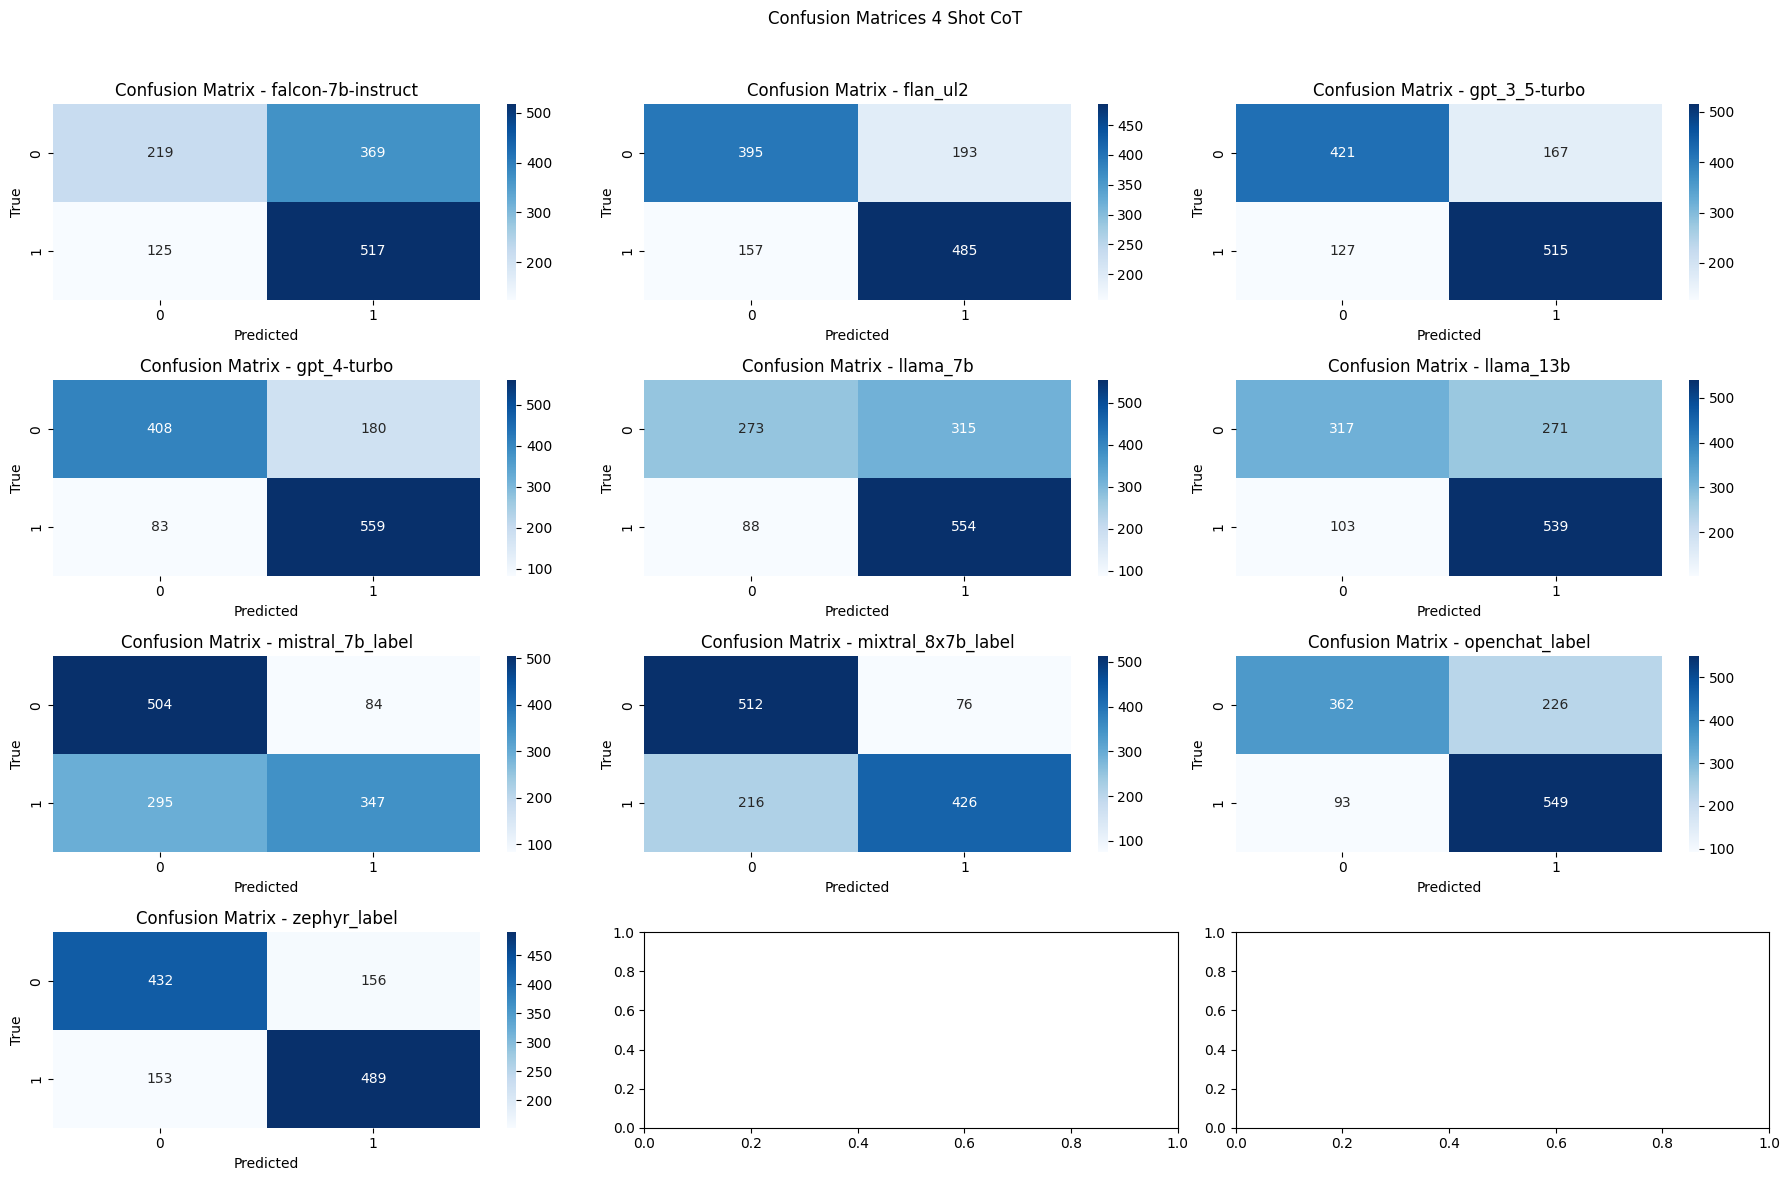

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(ax, df, true_labels_column, predicted_labels_column,
                          title=None
                          ):
    predicted_labels = df[f'{predicted_labels_column}'].astype(int)
    true_labels = df[f'{true_labels_column}'].astype(int)

    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)


    # Display confusion matrix heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True,
                yticklabels=True, ax=ax)

    title = title if title else predicted_labels_column

    ax.set_title(f'Confusion Matrix - {title}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')


# Create subplots
fig, axes = plt.subplots(4, 3, figsize=(18, 12))
fig.suptitle('Confusion Matrices 4 Shot CoT')


#df_falcon_7b = pd.read_csv(f"./data/falcon-7b-instruct.csv")
#df_flan_ul2 = pd.read_csv(f"./data/flan-ul2.csv")
#df_openai_gpt_3_5_turbo = pd.read_csv('/homeanonymousPycharmProjects/Annomatic_Benchmark/4-shot-CoT/data/gpt-3.5-turbo.csv')
#df_openai_gpt_4_turbo = pd.read_csv(f"./data/gpt-4-1106-preview.csv")
#df_Llama_2_7b = pd.read_csv(f"./data/Llama-2-7b-chat-hf.csv")
#df_Llama_2_13b = pd.read_csv(f"./data/Llama-2-13b-chat-hf.csv")
#df_mistral_7b = pd.read_csv(f"./data/Mistral-7B-Instruct-v0.1.csv")
#df_mixtral_8x7b = pd.read_csv(f"./data/Mixtral-8x7B-Instruct-v0.1.csv")
#df_openchat_3_5 = pd.read_csv(f"./data/openchat_3.5.csv")
#df_zephyr_7b_beta = pd.read_csv(f"./data/zephyr-7b-beta.csv")


# Plot each confusion matrix
plot_confusion_matrix(axes[0, 0], df_merge_all_runs, 'label', 'falcon_7b_label', 'falcon-7b-instruct')
plot_confusion_matrix(axes[0, 1], df_merge_all_runs, 'label', 'flan_ul2_label', 'flan_ul2')
plot_confusion_matrix(axes[0, 2], df_merge_all_runs, 'label', 'gpt_3_5_label', 'gpt_3_5-turbo')
plot_confusion_matrix(axes[1, 0], df_merge_all_runs, 'label', 'gpt_4_label', 'gpt_4-turbo')
plot_confusion_matrix(axes[1, 1], df_merge_all_runs, 'label', 'llama_7b_label', 'llama_7b')
plot_confusion_matrix(axes[1, 2], df_merge_all_runs, 'label', 'llama_13b_label', 'llama_13b')
plot_confusion_matrix(axes[2, 0], df_merge_all_runs, 'label', 'mistral_7b_label', 'mistral_7b_label')
plot_confusion_matrix(axes[2, 1], df_merge_all_runs, 'label', 'mixtral_8x7b_label', 'mixtral_8x7b_label')
plot_confusion_matrix(axes[2, 2], df_merge_all_runs, 'label', 'openchat_label', 'openchat_label')
plot_confusion_matrix(axes[3, 0], df_merge_all_runs, 'label', 'zephyr_label', 'zephyr_label')




plt.tight_layout(
    rect=[0, 0, 1, 0.96])  # Adjust layout to prevent title overlap
plt.show()

# Krippendorff Alpha in 4-shot CoT

In [55]:
from krippendorff import alpha
import numpy as np

runs = ['falcon_7b_label', 'flan_ul2_label',
       'gpt_3_5_label', 'gpt_4_label', 'llama_7b_label', 'llama_13b_label',
       'mistral_7b_label', 'mixtral_8x7b_label', 'openchat_label',
       'zephyr_label']


def compute_krippendorff_alpha(dataframe, columns, missing_data='?'):
    """
    Compute Krippendorff's alpha for inter-rater reliability.

    Parameters:
    - dataframe: pd.DataFrame, the DataFrame containing the data.
    - columns: list, the list of column names to calculate alpha for.

    Returns:
    - alpha_value: float, Krippendorff's alpha value.
    """
    # Extract the relevant columns from the DataFrame
    data_subset = dataframe[columns]
    data_subset = data_subset.replace(missing_data, np.nan)

    # Ensure that the data is in a format suitable for krippendorff
    data_list = np.array([data_subset[col].tolist() for col in columns])

    # Calculate Krippendorff's alpha
    alpha_value = alpha(reliability_data=data_list)

    return alpha_value

In [56]:
alpha_value_with_errors = compute_krippendorff_alpha(df_merge_all_runs_with_errors, runs)
alpha_value_without_errors = compute_krippendorff_alpha(df_merge_all_runs, runs)

print(f"Krippendorff's Alpha (all runs with invalid data): {alpha_value_with_errors}")
print(f"Krippendorff's Alpha (all runs without invalid data): {alpha_value_without_errors}")

Krippendorff's Alpha (all runs with invalid data): 0.49013695463466145
Krippendorff's Alpha (all runs without invalid data): 0.45873492699627516


In [57]:
import itertools

def compute_krippendorff_alpha_for_k_runs(df, runs, k=None):
    # Initialize variables to store the best combination and alpha
    if k is None:
        k = len(runs)

    best_combination = None
    best_alpha = 0  # Assuming alpha ranges from 0 to 1

    # Iterate through all possible combinations
    for combination in itertools.combinations(runs, k):

        alpha_value = compute_krippendorff_alpha(df, list(combination))

        # Print alpha for the current combination
        print(f"Combination: {combination}, Alpha: {alpha_value}")

        # Update best combination and alpha if a higher alpha is found
        if alpha_value > best_alpha:
            best_alpha = alpha_value
            best_combination = combination

    # Print the best combination and alpha
    print(f"\nBest Combination: {best_combination}, Best Alpha: {best_alpha}")
    return best_alpha, best_combination

In [58]:
compute_krippendorff_alpha_for_k_runs(df_merge_all_runs, runs, 3)

Combination: ('falcon_7b_label', 'flan_ul2_label', 'gpt_3_5_label'), Alpha: 0.3118437086060044
Combination: ('falcon_7b_label', 'flan_ul2_label', 'gpt_4_label'), Alpha: 0.29436605211659284
Combination: ('falcon_7b_label', 'flan_ul2_label', 'llama_7b_label'), Alpha: 0.2774663283066533
Combination: ('falcon_7b_label', 'flan_ul2_label', 'llama_13b_label'), Alpha: 0.2643688719998566
Combination: ('falcon_7b_label', 'flan_ul2_label', 'mistral_7b_label'), Alpha: 0.20362262588624958
Combination: ('falcon_7b_label', 'flan_ul2_label', 'mixtral_8x7b_label'), Alpha: 0.2501460426611476
Combination: ('falcon_7b_label', 'flan_ul2_label', 'openchat_label'), Alpha: 0.3147308424174895
Combination: ('falcon_7b_label', 'flan_ul2_label', 'zephyr_label'), Alpha: 0.30426629261119187
Combination: ('falcon_7b_label', 'gpt_3_5_label', 'gpt_4_label'), Alpha: 0.3594564751686291
Combination: ('falcon_7b_label', 'gpt_3_5_label', 'llama_7b_label'), Alpha: 0.33675436645935675
Combination: ('falcon_7b_label', 'gpt_3_

(0.6750827447531078, ('gpt_3_5_label', 'openchat_label', 'zephyr_label'))

In [59]:
compute_krippendorff_alpha_for_k_runs(df_merge_all_runs_with_errors, runs, 3)

Combination: ('falcon_7b_label', 'flan_ul2_label', 'gpt_3_5_label'), Alpha: 0.44468220829299043
Combination: ('falcon_7b_label', 'flan_ul2_label', 'gpt_4_label'), Alpha: 0.45651345889290695
Combination: ('falcon_7b_label', 'flan_ul2_label', 'llama_7b_label'), Alpha: 0.3425647105315155
Combination: ('falcon_7b_label', 'flan_ul2_label', 'llama_13b_label'), Alpha: 0.3368188724731789
Combination: ('falcon_7b_label', 'flan_ul2_label', 'mistral_7b_label'), Alpha: 0.28114314511172844
Combination: ('falcon_7b_label', 'flan_ul2_label', 'mixtral_8x7b_label'), Alpha: 0.3669067220624921
Combination: ('falcon_7b_label', 'flan_ul2_label', 'openchat_label'), Alpha: 0.4382436090470504
Combination: ('falcon_7b_label', 'flan_ul2_label', 'zephyr_label'), Alpha: 0.4303633952101832
Combination: ('falcon_7b_label', 'gpt_3_5_label', 'gpt_4_label'), Alpha: 0.526537452937395
Combination: ('falcon_7b_label', 'gpt_3_5_label', 'llama_7b_label'), Alpha: 0.40016183957651974
Combination: ('falcon_7b_label', 'gpt_3_5

(0.67621374672692, ('gpt_3_5_label', 'openchat_label', 'zephyr_label'))

In [60]:
df_merge_all_runs.shape

(1230, 21)

In [61]:
df_merge_all_runs.query("gpt_4_label != mixtral_8x7b_label").shape

(263, 21)